In [1]:
import numpy as np
import cv2
import pandas as pd
import torch
import torch.nn as nn
import os
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T

import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
import re
from tqdm.notebook import tqdm
from collections import Counter
import matplotlib.pyplot as plt
import copy

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
STOP_WORDS_EN = set(stopwords.words('english'))
STEMMER = SnowballStemmer('romanian')
MAX_LEN = 32
WORD_TO_INDEX = None

def get_tokens(caption):
    caption = caption.lower()
    
    caption = re.sub(r'[^\w\s]', ' ', caption)
    caption = re.sub(r'\s+', ' ', caption)
    caption = word_tokenize(caption)
    
    tokens = []
    for word in caption:
        if word not in STOP_WORDS_EN:
            stemmed_word = STEMMER.stem(word)
            tokens.append(stemmed_word)
    
    return tokens

def build_vocab(tokenized_captions):
    vocab = Counter(word for sent in tokenized_captions for word in sent)
    
    word_to_index = {}
    word_to_index["<mask>"] = 0 
    word_to_index["<pad>"] = 1
    word_to_index["<unk>"] = 2

    for id, (word, _) in enumerate(vocab.items()):
        word_to_index[word] = id+3
    
    return word_to_index

class CaptionsDataset(Dataset):
    def __init__(self, root, split):
        global WORD_TO_INDEX
        csv_file = pd.read_csv(os.path.join(root, f"{split}.csv"))
        self.split = split

        captions = csv_file["caption"].to_numpy()
        
        tokenized_captions = []
        for caption in captions:
            tokenized_captions.append(get_tokens(caption))

        if split == "train":
            WORD_TO_INDEX = build_vocab(tokenized_captions)
        
        encoded_captions = []
        masked_captions = []
        self.labels = []
        for tokenized_caption in tokenized_captions:
            encoded_caption = []
            for token in tokenized_caption:
                if token in WORD_TO_INDEX:
                    encoded_caption.append(WORD_TO_INDEX[token])
                else:
                    encoded_caption.append(WORD_TO_INDEX["<unk>"])

            encoded_captions.append(encoded_caption)

            mask_idx = np.random.randint(len(encoded_caption))
            masked_caption = copy.deepcopy(encoded_caption)
            masked_caption[mask_idx] = WORD_TO_INDEX["<mask>"]

            self.labels.append(encoded_caption[mask_idx])
            masked_captions.append(masked_caption)
        
        encoded_captions_padded = []
        masked_captions_padded = []
        for encoded_caption, masked_caption in zip(encoded_captions, masked_captions):
            num_pads = MAX_LEN - len(encoded_caption)
            encoded_captions_padded.append(encoded_caption[:MAX_LEN] + [WORD_TO_INDEX["<pad>"]]*num_pads)
            masked_captions_padded.append(masked_caption[:MAX_LEN] + [WORD_TO_INDEX["<pad>"]]*num_pads)

        self.data = [encoded_captions_padded, masked_captions_padded]

    def __len__(self):
        return len(self.data[0])
        
    def __getitem__(self, idx):
        sample = self.data[0][idx]
        sample = torch.tensor(sample).int()

        masked_sample = self.data[1][idx]
        masked_sample = torch.tensor(masked_sample).int()

        label = self.labels[idx]
        
        return masked_sample, label

In [3]:
class LanguageModel(nn.Module):
    def __init__(self, params):
        super(LanguageModel, self).__init__()
        if len(params) > 0:
            vocab_size = params["vocab_size"]
            embed_dim = params["embed_dim"]
            hidden_dim = params["hidden_dim"]
            num_layers = params["num_layers"]
            
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        x = self.embedding(x)
        _, (hidden_state, _) = self.lstm(x)
        out = self.linear(hidden_state[-1])
        return out

In [4]:
batch_size = 64
lr = 1e-3
epochs = 50
device = "cuda" if torch.cuda.is_available() else "cpu"

root = "/kaggle/input/image-sentence-pair-matching"

train_dataset = CaptionsDataset(root, "train")
val_dataset = CaptionsDataset(root, "val")

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

params = {
    "vocab_size": len(WORD_TO_INDEX), 
    "embed_dim": 256,
    "hidden_dim": 512,
    "num_layers": 1
}

In [5]:
def train_step(model, train_loader, optimizer, loss_fn):
    model.train()
    total_loss = 0.0
    correct_preds = 0.0
    total_preds = 0

    for txt_inputs, labels in tqdm(train_loader):
        txt_inputs, labels = txt_inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        
        outputs = model(txt_inputs)
        loss = loss_fn(outputs, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        predictions = torch.argmax(outputs, dim=1)
        correct_preds += torch.sum(predictions == labels).item()
        total_preds += labels.shape[0]

    train_step_loss = total_loss / len(train_loader)
    train_step_acc = correct_preds / total_preds

    return train_step_loss, train_step_acc

def val_step(model, val_loader, loss_fn):
    model.eval()
    total_loss = 0.0
    correct_preds = 0.0
    total_preds = 0

    with torch.no_grad():
        for txt_inputs, labels in tqdm(val_loader):
            txt_inputs, labels = txt_inputs.to(device), labels.to(device)

            outputs = model(txt_inputs)
            loss = loss_fn(outputs, labels)
    
            total_loss += loss.item()
            predictions = torch.argmax(outputs, dim=1)
            correct_preds += torch.sum(predictions == labels).item()
            total_preds += labels.shape[0]

    val_step_loss = total_loss / len(val_loader)
    val_step_acc = correct_preds / total_preds

    return val_step_loss, val_step_acc

def train():
    model = LanguageModel(params).to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()

    best_acc = 0.0
    best_model = None

    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    
    for epoch in range(epochs):
        print(f"epoch: {epoch+1}")
        train_step_loss, train_step_acc = train_step(model, train_dataloader, optimizer, loss_fn)
        print(f"train_step_loss: {train_step_loss} | train_step_acc = {train_step_acc}")
        
        val_step_loss, val_step_acc = val_step(model, val_dataloader, loss_fn)
        print(f"val_step_loss: {val_step_loss} | val_step_acc = {val_step_acc}")

        train_losses.append(train_step_loss)
        train_accs.append(train_step_acc)
        val_losses.append(val_step_loss)
        val_accs.append(val_step_acc)

        if val_step_acc > best_acc:
            best_acc = val_step_acc
            best_model = model

        torch.save(best_model.state_dict(), "language_model.pt")

    plt.plot(range(epochs), train_losses)
    plt.title("Train loss")
    plt.savefig("train_loss.jpg")
    plt.plot()
    
    plt.plot(range(epochs), train_accs)
    plt.title("Train acc")
    plt.savefig("train_acc.jpg")
    plt.plot()
    
    plt.plot(range(epochs), val_losses)
    plt.title("Val loss")
    plt.savefig("val_loss.jpg")
    plt.plot()
    
    plt.plot(range(epochs), val_accs)
    plt.title("Val acc")
    plt.savefig("val_acc.jpg")
    plt.plot()

epoch: 1


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 6.8998219982074325 | train_step_acc = 0.0165


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 6.762306264106264 | val_step_acc = 0.011333333333333334
epoch: 2


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 6.520487609182953 | train_step_acc = 0.0191


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 6.831196369008815 | val_step_acc = 0.019666666666666666
epoch: 3


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 6.495678124154449 | train_step_acc = 0.0183


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 6.8890686643884536 | val_step_acc = 0.019666666666666666
epoch: 4


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 6.484979987903765 | train_step_acc = 0.0202


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 6.901280372700793 | val_step_acc = 0.019666666666666666
epoch: 5


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 6.443889493395568 | train_step_acc = 0.0227


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 6.818191741375213 | val_step_acc = 0.021333333333333333
epoch: 6


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 6.339774289708228 | train_step_acc = 0.0258


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 6.783122874320822 | val_step_acc = 0.022
epoch: 7


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 6.207858410610515 | train_step_acc = 0.0299


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 6.692283955026181 | val_step_acc = 0.02666666666666667
epoch: 8


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 5.991867129210454 | train_step_acc = 0.0405


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 6.63782850224921 | val_step_acc = 0.043333333333333335
epoch: 9


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 5.7221652261770455 | train_step_acc = 0.0601


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 6.456309075051165 | val_step_acc = 0.057666666666666665
epoch: 10


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 5.385352796809689 | train_step_acc = 0.0884


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 6.413868782368112 | val_step_acc = 0.081
epoch: 11


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 4.999079944221837 | train_step_acc = 0.131


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 6.308681944583324 | val_step_acc = 0.104
epoch: 12


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 4.616447322687526 | train_step_acc = 0.172


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 6.249048557687313 | val_step_acc = 0.112
epoch: 13


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 4.199217615613512 | train_step_acc = 0.2221


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 6.106465765770445 | val_step_acc = 0.13566666666666666
epoch: 14


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 3.7657970805077037 | train_step_acc = 0.2759


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 6.201790576285505 | val_step_acc = 0.15166666666666667
epoch: 15


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 3.341695434728246 | train_step_acc = 0.3349


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 6.1354173295041345 | val_step_acc = 0.17733333333333334
epoch: 16


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 2.8729170158410526 | train_step_acc = 0.4144


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 6.310348896270103 | val_step_acc = 0.19033333333333333
epoch: 17


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 2.4508365506579164 | train_step_acc = 0.4929


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 6.3702463494970445 | val_step_acc = 0.20466666666666666
epoch: 18


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 2.0661838980996685 | train_step_acc = 0.56


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 6.487469602138438 | val_step_acc = 0.23233333333333334
epoch: 19


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 1.6915922354740702 | train_step_acc = 0.6402


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 6.723112207777957 | val_step_acc = 0.241
epoch: 20


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 1.399002372079594 | train_step_acc = 0.7054


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 6.807651255993133 | val_step_acc = 0.25266666666666665
epoch: 21


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 1.1144551574044925 | train_step_acc = 0.7758


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 7.023638380334733 | val_step_acc = 0.26466666666666666
epoch: 22


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 0.8734499329973937 | train_step_acc = 0.8301


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 7.1926051099249655 | val_step_acc = 0.2723333333333333
epoch: 23


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 0.6747268732565983 | train_step_acc = 0.8765


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 7.303602705610559 | val_step_acc = 0.2796666666666667
epoch: 24


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 0.5122063531997098 | train_step_acc = 0.9101


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 7.378754240401248 | val_step_acc = 0.2773333333333333
epoch: 25


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 0.3834452313032879 | train_step_acc = 0.9392


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 7.570994397427174 | val_step_acc = 0.2866666666666667
epoch: 26


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 0.29621260836245905 | train_step_acc = 0.9566


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 7.735190848086742 | val_step_acc = 0.291
epoch: 27


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 0.21573734269210487 | train_step_acc = 0.9723


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 7.8667068785809455 | val_step_acc = 0.292
epoch: 28


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 0.16970026796790444 | train_step_acc = 0.9784


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 7.962213008961779 | val_step_acc = 0.28733333333333333
epoch: 29


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 0.12194289587390651 | train_step_acc = 0.9858


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 8.055612452486729 | val_step_acc = 0.28633333333333333
epoch: 30


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 0.09120598912333987 | train_step_acc = 0.989


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 8.149303831952684 | val_step_acc = 0.29
epoch: 31


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 0.06924395780464646 | train_step_acc = 0.9911


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 8.27372135000026 | val_step_acc = 0.2916666666666667
epoch: 32


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 0.04902198967660309 | train_step_acc = 0.9938


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 8.386486895540928 | val_step_acc = 0.28733333333333333
epoch: 33


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 0.0423401189244287 | train_step_acc = 0.9941


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 8.436602105485631 | val_step_acc = 0.291
epoch: 34


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 0.054165091163888096 | train_step_acc = 0.9933


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 8.513337155605884 | val_step_acc = 0.2936666666666667
epoch: 35


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 0.04126290857174974 | train_step_acc = 0.9935


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 8.565967640978224 | val_step_acc = 0.2926666666666667
epoch: 36


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 0.04202474089588519 | train_step_acc = 0.9928


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 8.584504462302998 | val_step_acc = 0.2916666666666667
epoch: 37


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 0.04797817606502657 | train_step_acc = 0.993


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 8.618002536449026 | val_step_acc = 0.292
epoch: 38


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 0.1030669064397455 | train_step_acc = 0.9834


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 8.37257900643856 | val_step_acc = 0.2803333333333333
epoch: 39


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 0.4335865437699731 | train_step_acc = 0.899


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 8.058983914395595 | val_step_acc = 0.27
epoch: 40


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 0.43128336178269355 | train_step_acc = 0.9014


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 8.12719007248574 | val_step_acc = 0.28
epoch: 41


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 0.18043970459016265 | train_step_acc = 0.9647


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 8.4194338068049 | val_step_acc = 0.295
epoch: 42


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 0.0841757110112412 | train_step_acc = 0.9863


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 8.543239623942274 | val_step_acc = 0.295
epoch: 43


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 0.04878484989237634 | train_step_acc = 0.993


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 8.64516788847903 | val_step_acc = 0.297
epoch: 44


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 0.02513158028340264 | train_step_acc = 0.9954


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 8.788698419611505 | val_step_acc = 0.294
epoch: 45


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 0.019765170282168183 | train_step_acc = 0.9955


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 8.850510617519946 | val_step_acc = 0.29633333333333334
epoch: 46


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 0.01689379505077555 | train_step_acc = 0.9962


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 8.894705356435573 | val_step_acc = 0.2946666666666667
epoch: 47


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 0.015838982380191043 | train_step_acc = 0.9954


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 8.956901448838254 | val_step_acc = 0.2946666666666667
epoch: 48


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 0.014943934244453717 | train_step_acc = 0.9954


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 9.012327173922925 | val_step_acc = 0.2946666666666667
epoch: 49


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 0.014029408917780135 | train_step_acc = 0.9959


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 9.023860464704798 | val_step_acc = 0.297
epoch: 50


  0%|          | 0/157 [00:00<?, ?it/s]

train_step_loss: 0.0134094378756727 | train_step_acc = 0.9957


  0%|          | 0/47 [00:00<?, ?it/s]

val_step_loss: 9.09481213955169 | val_step_acc = 0.2966666666666667


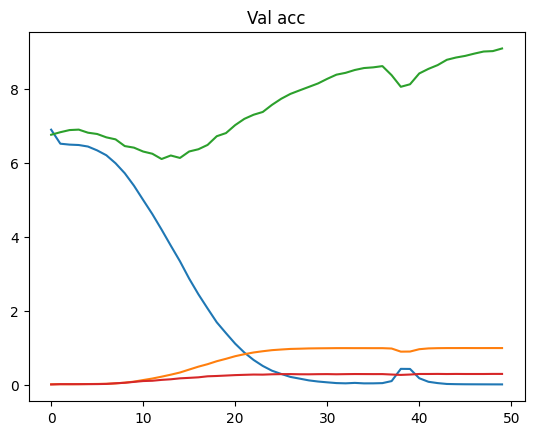

In [6]:
train()